# Hiver 2024 - Travail pratique 2

Remise électronique sur ZoneCours au plus tard le **10 avril à 23h55** de:

* Ce Jupyter notebook (.ipynb) en guise de rapport, une fois les réponses ajoutées. 
* **Tous** les fichiers *.py* nécessaires pour l'exécution du notebook

Le rapport **doit**:

* être en format .ipynb (des points seront enlevés pour tout autre format).
* inclure le numéro de matricule de tous les membres de l'équipe dans la première cellule (i.e. remplacez ces consignes)
* répondre aux questions et discuter des résultats à l'aide de tables, graphiques, et cellules markdown

Barème:

* **40%** Exactitude des résultats
* **25%** Discussions complètes et **concises** (cellules ``markdown'')
* **20%** Concision du notebook (.ipynb avec minimum de code) et clarté des graphiques
* **15%** Clarté du code (.py)

MEMBRE DU GROUPE :
NASSER HARORLD K DIALLO :11321834
SAMA Michel 11323661
Louis Bagio KAKPOVI 11334358

In [1]:
%matplotlib inline
 
import internal_script

import datetime as dt
import numpy as np
import os
import pandas as pd
import pandas_datareader as pdr
import yfinance as yf
#!gcc -shared -o dorion_francois/volatility_filters.so dorion_francois/volatility_filters.c -fPIC -lm

from dorion_francois.garch2_ import agarch, plot_parameter_series,calcul_prix_options
from dorion_francois.toolkit import print_versions, subcalendar, tic, toc,printdf
from dorion_francois.black_merton_scholes import _implied_volatility,option_price
#from dorion_francois.yf_utils import check_stock_splits

print_versions() # Versions of the critical dependencies
import warnings

# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", message=".*Scaled pvalue for parameter.*")


Python: 3.11.7
Numpy: 1.26.4
Pandas: 2.1.4


# Question 1

En vous inspirant du notebook 'ngarch_estimation.ipynb', estimez séquentiellement les paramètres d'un modèle **AGARCH** du 20 juillet, 2018, au 20 juillet 2023. Utilisez le même jeu de données. Notez que ces paramètres sont estimés sur les rendements excédentaires de l'indice de marché. Pourquoi est-il préférable de procéder ainsi? 

Représentez l'évolution des paramètres du modèle sur cette période en utilisant la fonction `plot_parameter_series(model, estimates)`, que vous adapterez au besoin. 

Discutez des aspects les plus marquants de ces différentes dynamiques et des moments qu'ils impliques.

In [2]:
if False:
    model_class = ngarch
    method,scaled,fname = 'Nelder-Mead',True,'ngarch_estimation.pkl'
else:
    model_class = agarch
    method,scaled,fname = 'Nelder-Mead',True,'agarch_estimation.pkl'
   

In [3]:
class Model(agarch):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        warnings.warn('Assignment 2 hack')
        self.fix_parameter('omega', 0)    
        
        FF = pdr.get_data_famafrench('F-F_Research_Data_Factors_daily', start='1900-01-01')[0]
        
        # The Mkt-RF series is in simple returns %. Convert to log-returns
        FF['log_xret'] = np.log(1+FF['Mkt-RF']/100)        
        self.data = FF
    
        if False:
            # Work sequentially on the last 5 years.
            from dateutil.relativedelta import relativedelta
            five_years_ago = dt.datetime.today() - relativedelta(years=5)
            self.estimation_time_t0 = FF.index[np.where(FF.index >= five_years_ago)[0][0]]
        else:
            # cf. the assert in estimate_sequentially
            #    assert estimates.index[0]==self.estimation_time_t0, 'Updating with inconsistent time_t0'
            self.estimation_time_t0 = pd.Timestamp('2018-07-20 00:00:00')
                
model = Model()
model.get_pv()

C:\Users\harol\AppData\Local\Temp\ipykernel_11748\3806255922.py:5: UserWarning: Assignment 2 hack
  warnings.warn('Assignment 2 hack')


{'lmbda': 0.0, 'omega': 0, 'alpha': 3e-06, 'beta': 0.9, 'gamma': 135}

In [4]:

last_date = pd.Timestamp('2023-07-20')
current_folder = os.getcwd()
filename = os.path.join(current_folder, fname)
if True:
    tic()    
    estimates = model.estimate_sequentially(method, scaled, filename, last_date)
    toc()
else:
    estimates = model.read_estimates(filename)
estimates



Updating from time_t: 2023-07-20 00:00:00


,lmbda,omega,alpha,beta,gamma,LL,nfev,erp,z_bar,z_std,z_skew,z_kurt,h_tp1
2023-07-20,0.999995,0.0,0.000006,0.869492,105.275121,85637.257812,129.0,0.013194,0.033662,0.99902,-0.615971,6.639608,0.000052


Elapsed time: 0.024056 seconds.



,lmbda,omega,alpha,beta,gamma,LL,nfev,erp,z_bar,z_std,z_skew,z_kurt,h_tp1
Date,,,,,,,,,,,,,
2018-07-20,0.004179,0,0.000006,0.875359,106.476392,81750.226562,154,0.000040,0.042692,0.999155,-0.607094,6.958569,0.000038
2018-07-23,0.004179,0,0.000006,0.875359,106.476392,81754.359375,69,0.000036,0.042701,0.999136,-0.607129,6.958967,0.000035
2018-07-24,0.004280,0,0.000006,0.875382,106.643064,81758.507812,72,0.000033,0.042712,0.998959,-0.607668,6.968053,0.000031
2018-07-25,0.004280,0,0.000006,0.875382,106.643064,81761.664062,78,0.000034,0.042772,0.998982,-0.607654,6.967054,0.000032
2018-07-26,0.004280,0,0.000006,0.875382,106.643064,81765.867188,67,0.000035,0.042756,0.998965,-0.607614,6.967297,0.000033
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-14,0.999995,0,0.000006,0.869492,105.276344,85622.734375,128,0.010831,0.033630,0.999013,-0.615946,6.641120,0.000043
2023-07-17,0.999995,0,0.000006,0.869492,105.276344,85626.570312,137,0.009422,0.033657,0.999003,-0.616009,6.641195,0.000037
2023-07-18,0.999995,0,0.000006,0.869492,105.276419,85629.945312,122,0.008790,0.033706,0.999013,-0.616037,6.640637,0.000035


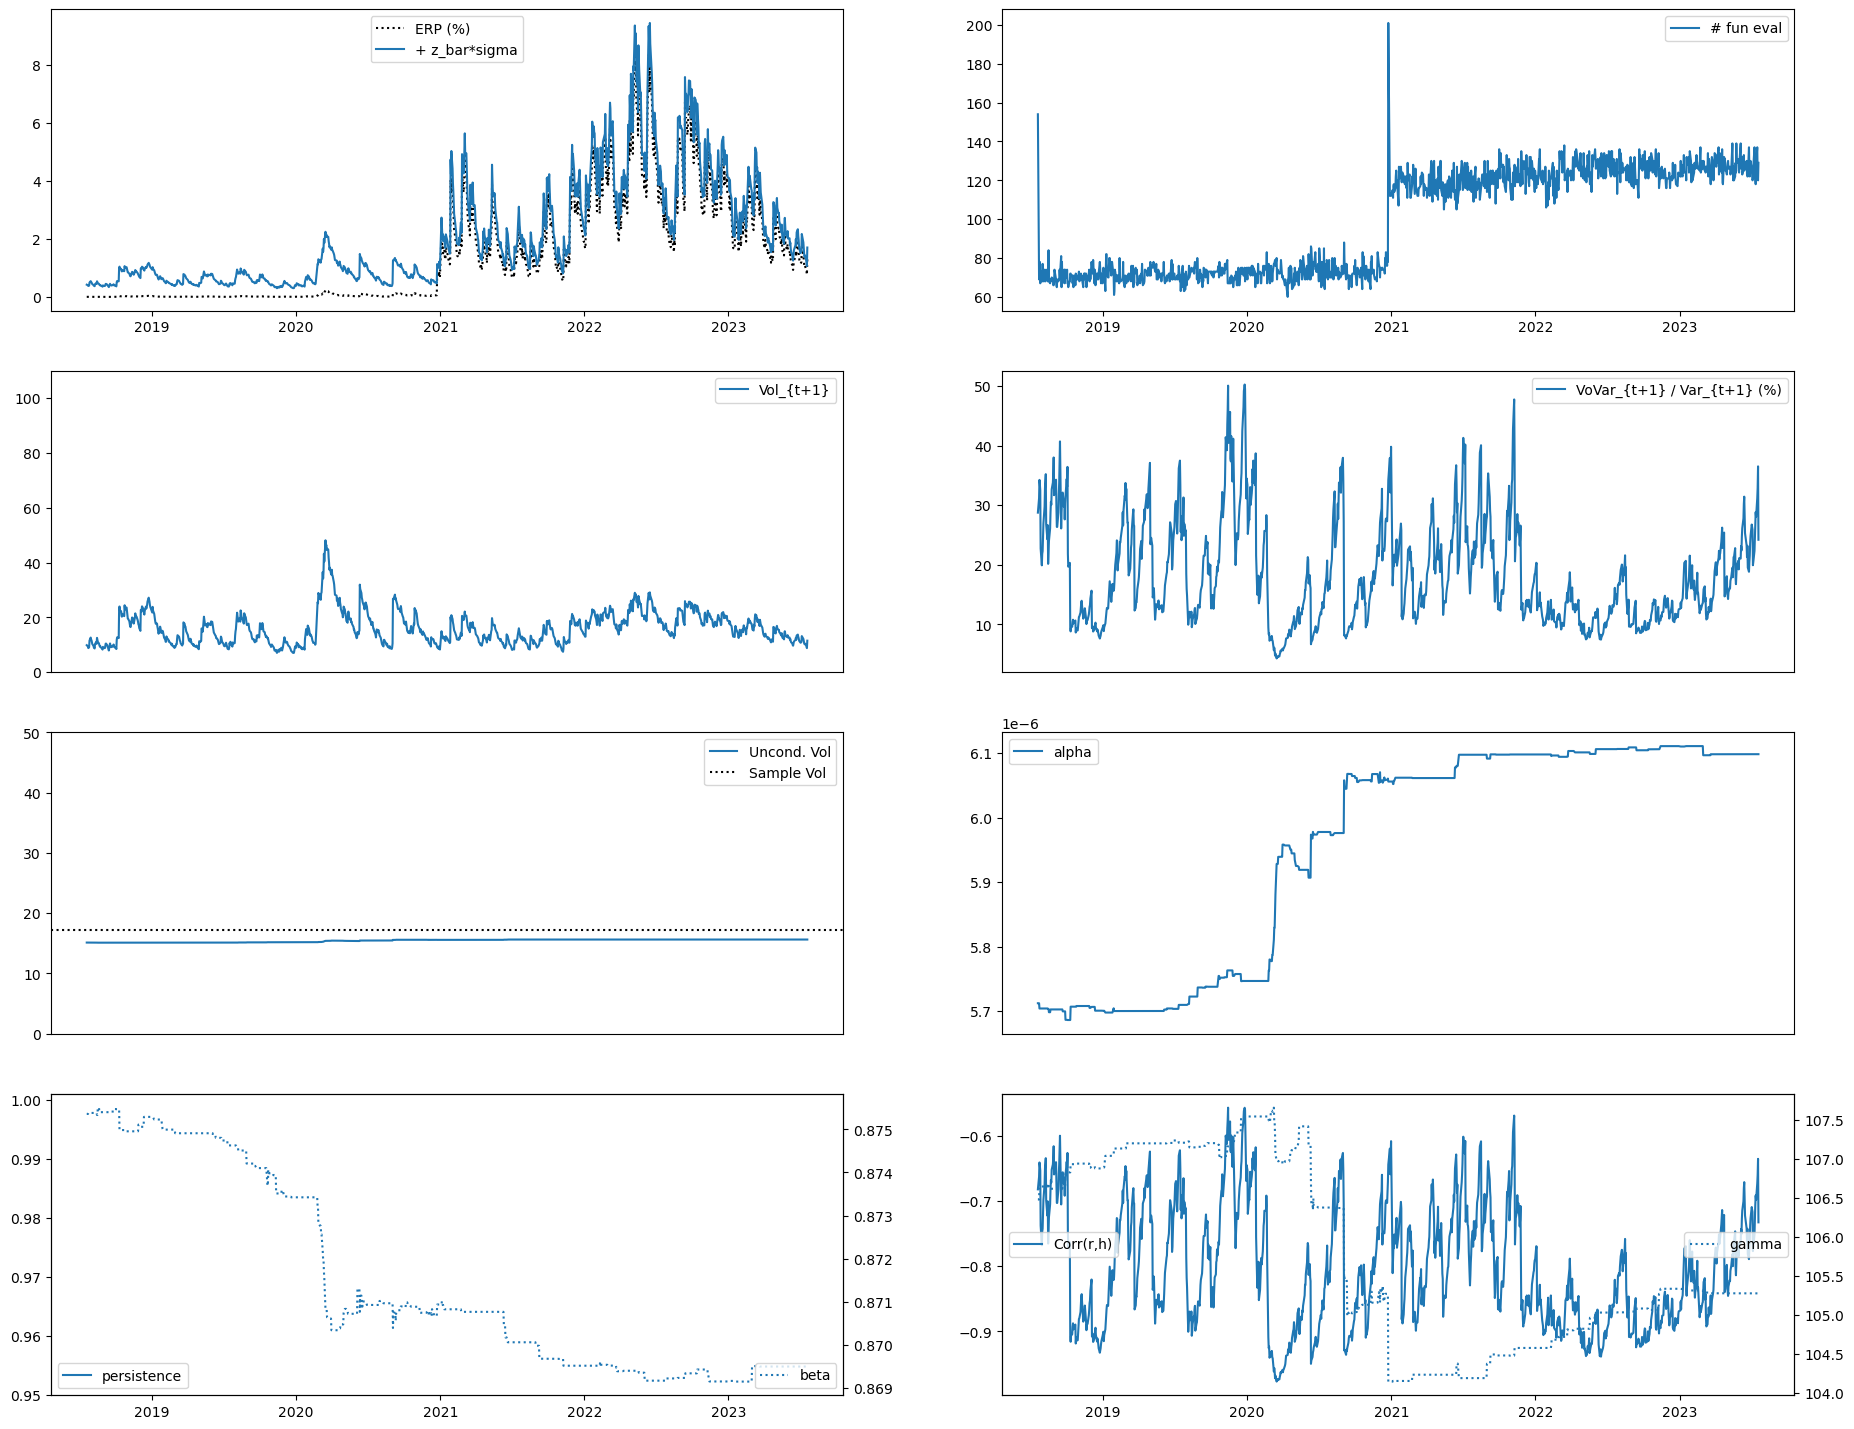

In [5]:
plot_parameter_series(model, estimates);

Discusion:
--L'utilisation des rendements excédentaire dans l'estimation des paramètre peut etre due a plusieurs raisons:
Utiliser des rendements excédentaires permet d'évaluer la rémunération pour avoir pris des risques supplémentaires par rapport à un investissement sans risque.En utilisant les rendements excédentaires, on sépare l'effet du temps (représenté par le taux sans risque) de l'effet du risque de marché. Cela aide à analyser plus précisément l'impact du risque sur les rendements  et aussi  les modèles GARCH capturent uniquement la volatilité qui est intrinsèque à l'actif lui-même.On ne peut occulter le fait  que les rendements excédentaires sont utilisés dans le processus d'évaluation neutre au risque qui est essentiel  a la tarification des options . Aussi,Les modèles GARCH sont conçus pour modéliser la volatilité des rendements. En utilisant des rendements excédentaires, on peut obtenir une meilleure estimation de la volatilité qui est due uniquement aux mouvements du marché, plutôt qu'à des variations de la structure de taux d'intérêt

-- Pour ce qui concerne l'évolution des  parametres(tous positifs) nous remarquons que le Gamma ou coeficient d'asymetrie (car il controle la skweness )est toujours positfs ce qui met en exergue la corrélation négative entre le rendement et la volatilité et  aussi que les mauvaises nouvelle  ont plus d'impact sur la volatilité.De plus le alpha qui messure le choc des innovations sur la variance (volatilité de la variance) controle le kurtosis(epaiseur de queue de la distribution) .Ce qui explique les  grandes  volatilité de la variance quand alpha augmente et  la distribution    leptokurtique des rendements  (kurtosis supérieure à celle d'une distribution normale).Pour ce qui concerne le beta  nous remarquons une correlation positive entre la perssistance (durée des effets des choc passé sur la volatilité future) et le beta  ce qui   veut dire qu'un beta plus elevé implique une plus grande persistance.On remarque aussi une corrélation positive des de la prime de risque de marché excédentaire(erp) qui est une fonction du lamba  avec les chocs de volatilité.

# Question 2

En itérant sur les paramètres trouvés en Question 1, calculez à chaque jour ouvrable les prix des options européennes suivantes sur l'indice:
Le taux sans risque doit être mis à jour quotidiennement à même le jeu de données utilisé. Le prix peut être obtenu par simulation, où à l'aide de la formule quasi-analytique. Si vous procédez par simulation, utilisez un nombre pair de simulations aussi grand que raisonnablement possible, avec des variables antithétiques.

Vous trouverez ensuite, pour chacune des options, la volatilité implicite (BMS) correspondant au prix obtenu à l'aide du AGARCH. À chaque jour, calculez IV_atm, le niveau de volatilité implicite de l'option à la monnaie (mny == 1), la pente slope = IV(1.0) - IV(0.8), où IV(mny) représente la volatilité implicite de l'option de degré d'enjeu mny.

Présentez dans une figure 1x2 (lignes x colonnes) la dynamique temporelle de ces deux séries. Discutez de leur évolution et de leur correlation l'une avec l'autre, et aussi avec les séries de paramètres.

In [6]:
F= 100                     # On normalise le prix forward à 100 chaque jour
Ks= np.arange(80,121,2.5)
T=1/12                        #maturité des options 
n = 21
n_paths = 10000        # nombre de simulations 
date_range = model.get_calendar(after=pd.Timestamp('2023-07-20'), last_date=pd.Timestamp('2023-07-20')+pd.offsets.BusinessDay(n))
n_days=len(date_range)
RF = np.array(model.data.loc[date_range, 'RF'])
h_tp1=(estimates["h_tp1"][-1])               #variance au début de la simulation 
val=calcul_prix_options(F,n_days, n_paths, h_tp1, RF, T, Ks)
printdf(pd.DataFrame(val, index=date_range, columns=Ks))


,80.0,82.5,85.0,87.5,90.0,92.5,95.0,97.5,100.0,102.5,105.0,107.5,110.0,112.5,115.0,117.5,120.0
Date,,,,,,,,,,,,,,,,,
2023-07-21,0.0,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.390060,0.000016,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
2023-07-24,0.0,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.002192,0.514742,0.004001,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
2023-07-25,0.0,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000035,0.013689,0.617635,0.016342,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
2023-07-26,0.0,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000649,0.029079,0.692693,0.031355,0.000230,0.000000,0.000000,0.000000,0.0,0.0,0.0
2023-07-27,0.0,0.000000,0.000000,0.000000e+00,0.000000,0.000077,0.002508,0.051901,0.766636,0.053155,0.000832,0.000000,0.000000,0.000000,0.0,0.0,0.0
2023-07-28,0.0,0.000000,0.000000,0.000000e+00,0.000000,0.000097,0.004575,0.080721,0.833930,0.079544,0.001467,0.000000,0.000000,0.000000,0.0,0.0,0.0
2023-07-31,0.0,0.000000,0.000000,0.000000e+00,0.000000,0.000428,0.008965,0.104164,0.891639,0.101814,0.003398,0.000052,0.000000,0.000000,0.0,0.0,0.0
2023-08-01,0.0,0.000000,0.000000,0.000000e+00,0.000025,0.000728,0.014576,0.133861,0.929541,0.125545,0.005595,0.000089,0.000000,0.000000,0.0,0.0,0.0
2023-08-02,0.0,0.000000,0.000000,0.000000e+00,0.000155,0.001841,0.019491,0.156990,0.979471,0.148081,0.008031,0.000177,0.000000,0.000000,0.0,0.0,0.0


# WITH BMS PRICE  FOR COMPARAISON SAKE 

In [7]:
y=0
T=1/12
BMS_PRICE= np.zeros((n_days, len(Ks)))
sig=np.sqrt(h_tp1*252)

for day in range(n_days):
    r=RF[day]
    for j, K in enumerate(Ks):  
        mny = K / 100 
        is_call = mny >= 1  
        BMS_PRICE[day,j]=option_price(100, K, r, y, T, sig, is_call, ret_delta=False)
pd.DataFrame(BMS_PRICE, index=date_range, columns=Ks)      

,80.0,82.5,85.0,87.5,90.0,92.5,95.0,97.5,100.0,102.5,105.0,107.5,110.0,112.5,115.0,117.5,120.0
Date,,,,,,,,,,,,,,,,,
2023-07-21,2.437775e-12,1.149770e-09,2.059553e-07,0.000015,0.000515,0.008500,0.074654,0.380312,1.415176,0.487852,0.120111,0.020685,0.002480,0.000208,0.000012,5.275968e-07,1.643178e-08
2023-07-24,2.437775e-12,1.149770e-09,2.059553e-07,0.000015,0.000515,0.008500,0.074654,0.380312,1.415176,0.487852,0.120111,0.020685,0.002480,0.000208,0.000012,5.275968e-07,1.643178e-08
2023-07-25,2.437775e-12,1.149770e-09,2.059553e-07,0.000015,0.000515,0.008500,0.074654,0.380312,1.415176,0.487852,0.120111,0.020685,0.002480,0.000208,0.000012,5.275968e-07,1.643178e-08
2023-07-26,2.437775e-12,1.149770e-09,2.059553e-07,0.000015,0.000515,0.008500,0.074654,0.380312,1.415176,0.487852,0.120111,0.020685,0.002480,0.000208,0.000012,5.275968e-07,1.643178e-08
2023-07-27,2.437775e-12,1.149770e-09,2.059553e-07,0.000015,0.000515,0.008500,0.074654,0.380312,1.415176,0.487852,0.120111,0.020685,0.002480,0.000208,0.000012,5.275968e-07,1.643178e-08
2023-07-28,2.437775e-12,1.149770e-09,2.059553e-07,0.000015,0.000515,0.008500,0.074654,0.380312,1.415176,0.487852,0.120111,0.020685,0.002480,0.000208,0.000012,5.275968e-07,1.643178e-08
2023-07-31,2.437775e-12,1.149770e-09,2.059553e-07,0.000015,0.000515,0.008500,0.074654,0.380312,1.415176,0.487852,0.120111,0.020685,0.002480,0.000208,0.000012,5.275968e-07,1.643178e-08
2023-08-01,2.526050e-12,1.186090e-09,2.115529e-07,0.000016,0.000525,0.008631,0.075550,0.383750,1.406617,0.483770,0.118790,0.020399,0.002438,0.000204,0.000012,5.140693e-07,1.596240e-08
2023-08-02,2.526050e-12,1.186090e-09,2.115529e-07,0.000016,0.000525,0.008631,0.075550,0.383750,1.406617,0.483770,0.118790,0.020399,0.002438,0.000204,0.000012,5.140693e-07,1.596240e-08


# IMPLIED VOLATILITY

In [8]:
sig=np.sqrt(h_tp1*252)
y=0
mny = Ks / F  # La définition de moneyness à utiliser
is_call = mny >= 1
implied_vol= np.zeros((n_days, len(Ks)))
for day in range(n_days):
        rday=RF[day]
        for j, K in enumerate(Ks):
            opt_price =val[day, j]
            is_call = mny[j] >= 1
            vol_imp = _implied_volatility(opt_price, F, K, rday, y, T, is_call, init_vol=0.6)
            implied_vol[day, j] = vol_imp
IV=pd.DataFrame(implied_vol, index=date_range, columns=Ks)
printdf(IV)


C:\ProgramData\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)
C:\Users\harol\AppData\Local\Temp\ipykernel_11748\2584978675.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  implied_vol[day, j] = vol_imp


,80.0,82.5,85.0,87.5,90.0,92.5,95.0,97.5,100.0,102.5,105.0,107.5,110.0,112.5,115.0,117.5,120.0
Date,,,,,,,,,,,,,,,,,
2023-07-21,0.033341,0.028798,0.024385,0.020094,0.015919,0.011855,0.007895,0.004036,0.025143,0.021345,0.006979,0.010473,0.013885,0.017217,0.020474,0.023657,0.026771
2023-07-24,0.033341,0.028798,0.024385,0.020094,0.015919,0.011855,0.007895,0.037711,0.036222,0.034805,0.006979,0.010473,0.013885,0.017217,0.020474,0.023657,0.026771
2023-07-25,0.033341,0.028798,0.024385,0.020094,0.015919,0.011855,0.049650,0.048448,0.045276,0.043098,0.006979,0.010473,0.013885,0.017217,0.020474,0.023657,0.026771
2023-07-26,0.033341,0.028798,0.024385,0.020094,0.015919,0.011855,0.061262,0.055425,0.051856,0.048790,0.050099,0.010473,0.013885,0.017217,0.020474,0.023657,0.026771
2023-07-27,0.033341,0.028798,0.024385,0.020094,0.015919,0.076379,0.069665,0.062586,0.058325,0.054815,0.055708,0.010473,0.013885,0.017217,0.020474,0.023657,0.026771
2023-07-28,0.033341,0.028798,0.024385,0.020094,0.015919,0.077532,0.074452,0.069578,0.064206,0.060626,0.058748,0.010473,0.013885,0.017217,0.020474,0.023657,0.026771
2023-07-31,0.033341,0.028798,0.024385,0.020094,0.015919,0.086137,0.080906,0.074423,0.069244,0.064867,0.064146,0.066057,0.013885,0.017217,0.020474,0.023657,0.026771
2023-08-01,0.033317,0.028774,0.024360,0.020069,0.094253,0.089711,0.086273,0.079571,0.073319,0.069321,0.068206,0.068496,0.013909,0.017242,0.020498,0.023682,0.026796
2023-08-02,0.033317,0.028774,0.024360,0.020069,0.105292,0.097374,0.090087,0.083500,0.077672,0.072949,0.071386,0.071711,0.013909,0.017242,0.020498,0.023682,0.026796


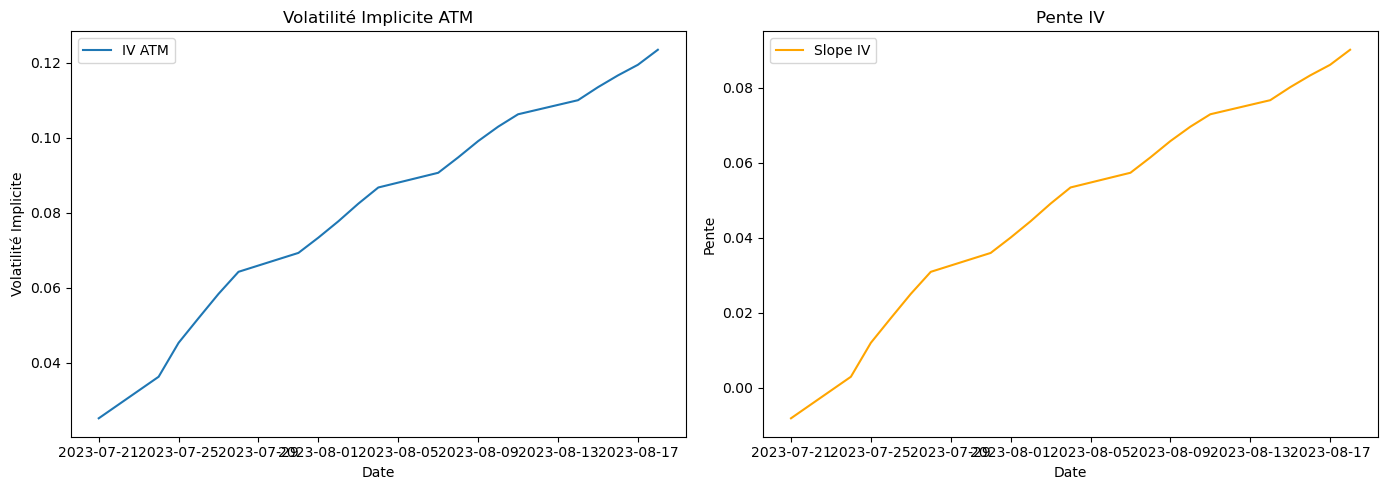

In [9]:
import matplotlib.pyplot as plt

iv_atm = implied_vol[:, np.argmin(abs(mny - 1.0))]
iv_mny_0_8 = implied_vol[:, np.argmin(abs(mny - 0.8))]
slope = iv_atm - iv_mny_0_8  # Calcul de la pente


df_iv_atm = pd.Series(iv_atm, index=date_range)
df_slope = pd.Series(slope, index=date_range)


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))


axes[0].plot(df_iv_atm, label='IV ATM')
axes[0].set_title('Volatilité Implicite ATM')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Volatilité Implicite')
axes[0].legend()

# Pente des IV
axes[1].plot(df_slope, color='orange', label='Slope IV')
axes[1].set_title('Pente IV')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Pente')
axes[1].legend()

plt.tight_layout()
plt.show()


Discusion :IV_atm: Cette série montre comment la volatilité implicite des options à la monnaie évolue dans le temps. Une volatilité plus élevée peut indiquer une plus grande incertitude ou de plus grandes attentes de mouvement de prix du sous-jacent.
Pour ce qui concerne la pente ou skew de volatilité entre les IV pour des moneyness de 1.0 et 0.8 reflète la forme de la surface de volatilité implicite.Vue la pente est positive, cela peut refléter une crainte de mouvements de baisse plus que de hausse(perception de risque d'asymetrie), car les options de put  OTM deviennent plus coûteuses relativement aux options call. Cette pente positive  peut egalement s'expliquer par le fait que le coeffiscient d'asymetrie Gamma soit egalement croissant dans le temps.Ce phénomène est souvent décrit comme un "skew" positif ou une asymétrie dans la surface de volatilité

# Question 3

Trouvez les dates auxquelles `IV_atm` atteint sa valeur minimum et sa valeur maximum. En excluant ces deux dates, trouvez les dates auxquelles `slope` atteint sa valeur minimum et sa valeur maximum.

Dans une figure 2x2, présentez le smile que vous avez obtenu sur ces quatres dates. Discutez de ces figures en établissant des liens avec votre réponse à la Question 2. 


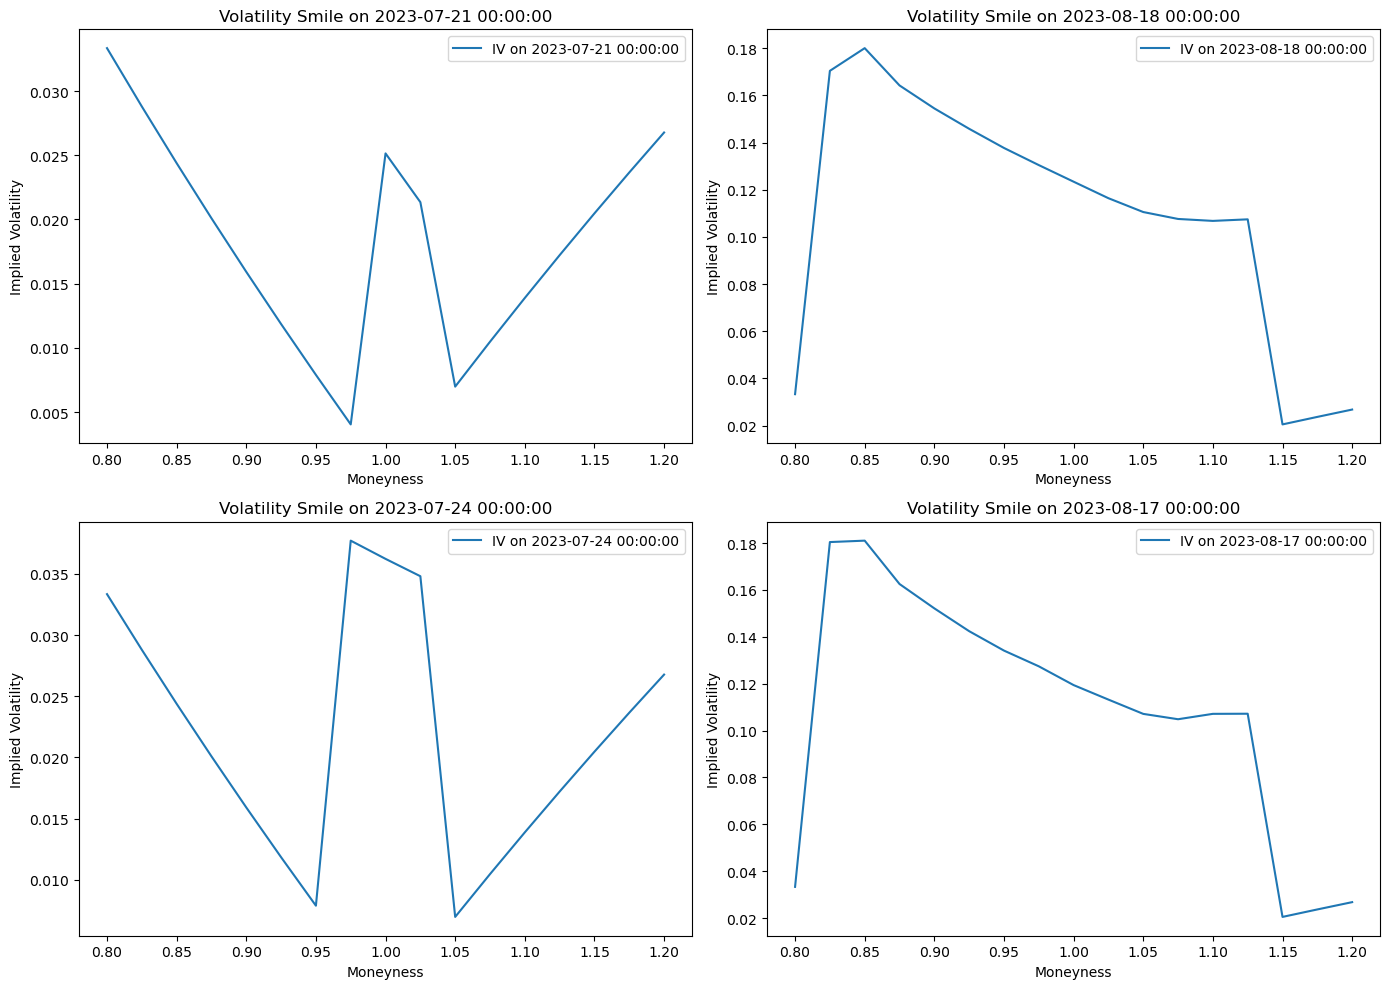

In [11]:

date_min_iv_atm = df_iv_atm.idxmin()
date_max_iv_atm = df_iv_atm.idxmax()

df_slope_excl = df_slope.drop([date_min_iv_atm, date_max_iv_atm])
date_min_slope = df_slope_excl.idxmin()
date_max_slope = df_slope_excl.idxmax()

# Créer une figure 2x2
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
dates_to_plot = [date_min_iv_atm, date_max_iv_atm, date_min_slope, date_max_slope]

for i, day in enumerate(dates_to_plot):
  
    axes[i//2, i%2].plot(mny, IV.loc[day, :], label=f'IV on {day}')
    axes[i//2, i%2].set_title(f'Volatility Smile on {day}')
    axes[i//2, i%2].set_xlabel('Moneyness')
    axes[i//2, i%2].set_ylabel('Implied Volatility')
    axes[i//2, i%2].legend()

plt.tight_layout()
plt.show()


Discusion:Comme deja mentionner dans la réponse de la question 2 , le skeness positif signifie que les volatilités implicites des puts OTM sont généralement plus élevées que celles des calls OTM. Cela est dû au fait que les investisseurs sont souvent plus préoccupés par les risques de baisse que par les possibilités de hausse, menant à une demande plus forte pour les puts OTM comme protection ou assurance contre les chutes des prix du sous-jacent.Nous pouvons ainsi confirmer ce phenomène dans les 4 graphiques(smirk) ci-dessus.

# Ecart du BMS et de la simulation at the money  

<Axes: >

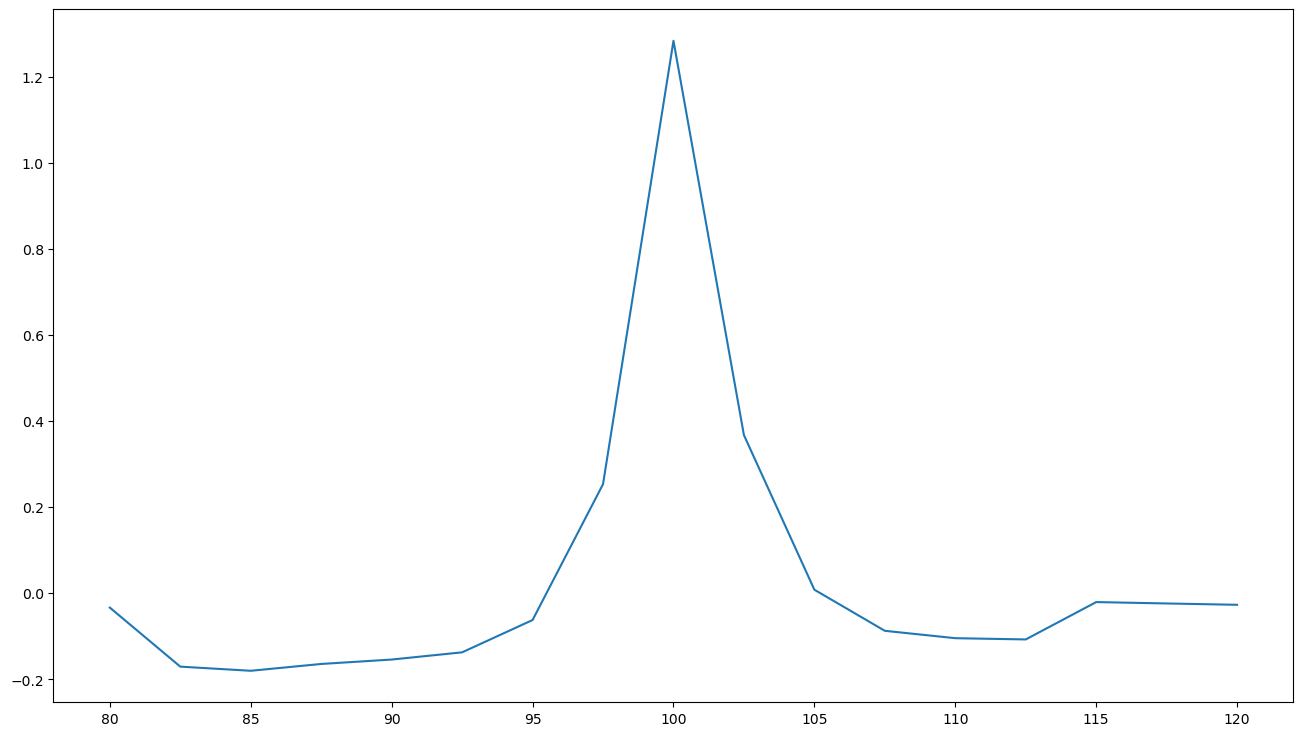

In [12]:
diff = BMS_PRICE - IV
diff.iloc[20,:].plot(figsize=(16,9))

# Question 4

Chaque jour, appliquez la formule du VIX sur les prix d'options obtenus pour obtenir un indice que nous appelerons le MVIX ('model VIX'). Dans une même figure 1x1, rapportez l'évolution du VIX (que vous téléchargerez du site du Cboe), du MVIX et celle de $h_{t+1}$. Comparez les trois séries et discuter des sources potentielles de divergences.

# Télechargement des données du vix à partir du site du Cboe

In [13]:

from datetime import datetime

file = 'VIX_History.csv'

analyse_date = lambda x: datetime.strptime(x, '%m/%d/%Y')

VIX_Cboe = pd.read_csv(file, date_parser=analyse_date, index_col='DATE')


VIX_Cboe = VIX_Cboe[(VIX_Cboe.index >= '2023-07-21') & (VIX_Cboe.index <= '2023-08-18')]
VIX_Cboe = (VIX_Cboe['HIGH'] + VIX_Cboe['LOW'])/2
VIX_Cboe.columns = ['VIX_Cboe']
VIX_Cboe

DATE
2023-07-21    13.630
2023-07-24    14.015
2023-07-25    13.955
2023-07-26    13.655
2023-07-27    13.880
2023-07-28    13.725
2023-07-31    13.830
2023-08-01    14.025
2023-08-02    15.715
2023-08-03    16.570
2023-08-04    15.980
2023-08-07    16.565
2023-08-08    17.050
2023-08-09    16.125
2023-08-10    15.730
2023-08-11    15.675
2023-08-14    15.415
2023-08-15    15.740
2023-08-16    16.365
2023-08-17    17.265
2023-08-18    18.010
dtype: float64

# Conversion des données h_tp1 en unité de grandeur que le VIX

In [14]:
h_tp1=(estimates["h_tp1"][-1])
Q_ex_r, h, _ = model.simulateQ(F,n_days, n_paths, h_tp1, z=None, pv=None)
h_tp1 = np.sqrt(np.mean(h,axis=1)*252)*100
h_tp1 = pd.DataFrame(h_tp1 , index=model.get_calendar(after=pd.Timestamp('2023-07-20'), last_date=pd.Timestamp('2023-07-20')+pd.offsets.BusinessDay(22)))
h_tp1 = h_tp1.drop(h_tp1.index[-1])
h_tp1.colums = 'h_tp1'
h_tp1

,0
Date,
2023-07-21,11.486559
2023-07-24,11.789052
2023-07-25,12.087192
2023-07-26,12.342108
2023-07-27,12.593083
2023-07-28,12.805265
2023-07-31,12.980775
2023-08-01,13.179055
2023-08-02,13.361308


In [15]:
def calculate_VIX(options_data, rate, T):
    F = 100
    delta_K = 2.5
    K0 = 97.5
    strike = np.arange(80, 121, 2.5)
    VIX = np.zeros(len(options_data.index))  
 
    for j in range(len(options_data.index)):  
        r = rate[j]  
      
        sum_term = 0
        for i in range(len(options_data.columns)):
            K = strike[i]
            Q = options_data.iloc[j,i]  
            sum_term += (delta_K / (K ** 2)) * Q * np.exp(r * T)
 
        
        term2 = (F / K0) - 1
 
        # Calcul du VIX
        VIX[j] = 100 * np.sqrt((2 / T) * (sum_term - (1 / T) * (term2 ** 2)))
    VIX = pd.Series(VIX, index=options_data.index) 
 
    return VIX

In [33]:
M=pd.DataFrame(val, index=date_range, columns=Ks)
MVIX = calculate_VIX(M,RF,1/12)
MVIX

C:\Users\harol\AppData\Local\Temp\ipykernel_31668\2575752792.py:21: RuntimeWarning: invalid value encountered in sqrt
  VIX[j] = 100 * np.sqrt((2 / T) * (sum_term - (1 / T) * (term2 ** 2)))


Date
2023-07-21   NaN
2023-07-24   NaN
2023-07-25   NaN
2023-07-26   NaN
2023-07-27   NaN
2023-07-28   NaN
2023-07-31   NaN
2023-08-01   NaN
2023-08-02   NaN
2023-08-03   NaN
2023-08-04   NaN
2023-08-07   NaN
2023-08-08   NaN
2023-08-09   NaN
2023-08-10   NaN
2023-08-11   NaN
2023-08-14   NaN
2023-08-15   NaN
2023-08-16   NaN
2023-08-17   NaN
2023-08-18   NaN
dtype: float64

Les résultats obtenus pour le MVIX ne sont malheureusement pas cohérents ; nous n'avons donc pas pu tracer le graphique ni faire une analyse

# Graphique des Trois mesures de risques

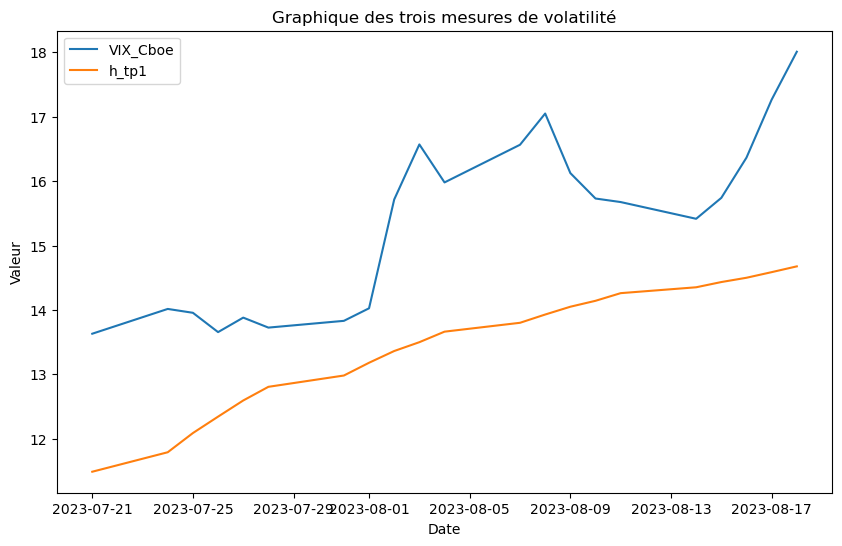

In [16]:

plt.figure(figsize=(10, 6))


plt.plot(VIX_Cboe.index, VIX_Cboe, label='VIX_Cboe')


plt.plot(h_tp1.index, h_tp1, label='h_tp1')




plt.title('Graphique des trois mesures de volatilité')
plt.xlabel('Date')
plt.ylabel('Valeur')


plt.legend()


plt.show()

Nous remarquons aussi Il semble que la volatilité du Cboe soit supérieure à celle de h_tp1. Cette différence peut être attribuée aux sources de données variées utilisées par les sites spécialisés. Le Cboe pourrait utiliser des données à plus haute fréquence, capturant ainsi plus de volatilités. Ces sites spécialisés, comme le Cboe, peuvent également utiliser des données en temps réel, ce qui diffère des variances simulées quotidiennement dans ce TP. De plus, les ajustements et corrections apportés peuvent jouer un rôle important dans les mesures de volatilité obtenues.


# Question 5

À tous les 21 jours ouvrables (`np.arange(0, len(data.index), 21)`), vous prenez une position longue sur un swap de variance. À l'aide du VIX (Cboe) et de la variance réalisée (selon le AGARCH) sur le mois qui suit, calculez le PnL de votre position. Tracez cette la série temporelle de vos PnL. Discutez de la série et de ses 4 premiers moments.

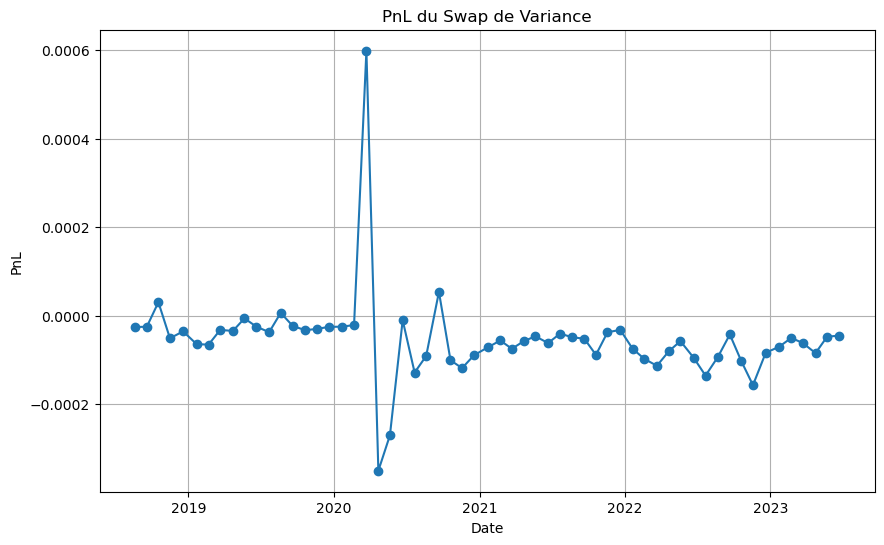

Moyenne du PnL: -5.370417512468935e-05
Variance du PnL: 1.0944859464806024e-08
Skewness du PnL: 3.667597608318963
Kurtosis du PnL: 26.456440958639178


In [19]:
Cboe = pd.read_csv(file, date_parser=analyse_date, index_col='DATE')
Cboe = Cboe[(Cboe.index >= '2018-07-20') & (Cboe.index <= '2023-07-20')]
Cboe = Cboe['CLOSE']

data=estimates.index
vix = (Cboe/(250*100))**2



AGARCH_estim =estimates["h_tp1"]



positions = np.arange(0, len(data), 21)  # Tous les 21 jours ouvrables
pnl = []

for pos in positions:
    if pos + 21 < len(data):
        realized_var = AGARCH_estim[pos:pos+21].var()
        vix_strike = vix.iloc[pos]
        pnl.append((realized_var - vix_strike / 100) * 10000)  

# Visualisation des PnL
plt.figure(figsize=(10, 6))
plt.plot(data[positions][1:], pnl, marker='o', linestyle='-')
plt.title('PnL du Swap de Variance')
plt.xlabel('Date')
plt.ylabel('PnL')
plt.grid(True)
plt.show()


print("Moyenne du PnL:", np.mean(pnl))
print("Variance du PnL:", np.var(pnl))
print("Skewness du PnL:", pd.Series(pnl).skew())
print("Kurtosis du PnL:", pd.Series(pnl).kurt())



La série temporelle du PnL montre une moyenne proche de zéro, indiquant un équilibre global entre gains et pertes. La faible variance suggère une stabilité des rendements. Cependant, une skewness positive et une kurtosis élevée révèlent une distribution asymétrique avec des gains potentiels plus extrêmes que les pertes. 